<h4 style="text-align: center; color: #BD6C37;"> <i> Ecole Polytechnique de Thiès <br>  Département Génie Informatique et Télécommunications </i> </h4>
<h1 style="text-align: center"> Principes MLOps </h1>
<h5 style="text-align: center">DIC3-GIT, 2023-2024</h5>
<h5 style="text-align: center">Mme Mously DIAW</h5>
<h1 style="text-align: center; color:#90edaa">Projet matière : Natural Language Processing with Disaster Tweets</h1>
<h5 style="text-align: center"> Par Kikia DIA, Mouhamadou Naby DIA, Ndeye Awa SALANE </h5>
<h3 style="text-align: center; color:#9000aa; text-decoration:underline"> II. Models </h3>


<a id="0"></a> <br>
### Sommaire
#### [Introduction](#1)
1. [Modèles Pre-entrainés: Bert, Roberta, etc.](#2)
1. [Modèles de Séquences: RNN, LSTM, GRU](#3)
1. [Modèles ML](#4)
#### [Conclusion](#5)
* <i>[References](#6)</i>
* <i>[Authors](#7)</i>

<a id="1"></a> 
#### Introduction [⏮️]()[👆🏽](#0)[⏭️](#2)

<div style="display: flex;">
     <div style="flex: 1;">
         <img src="https://storage.googleapis.com/kaggle-media/competitions/tweet_screenshot.png" alt="Descriptive Image" style="width: 100%; height:90%;">
     </div>
     <div style="flex: 
         4; padding-y: 10px; padding-left: 10px; text-align: justify">
         <p>
             🌀 Twitter est devenu un important canal de communication en cas d’urgence.
             <br><br>
             🌀 L’omniprésence des smartphones permet aux gens d’annoncer une urgence qu’ils observent en temps réel. Pour cette raison, de plus en plus d’organismes s’intéressent à la surveillance programmatique de Twitter (c.-à-d. les organisations de secours aux sinistrés et les agences de presse).
             <br><br>
             🌀 Mais on ne sait pas toujours si les paroles d’une personne annoncent réellement un désastre (comme en témoigne l'image ci-contre).
             <br><br>
             🌀 L’auteur utilise explicitement le mot « ABLAZE » (qui veut dire "En Feu") mais le dit métaphoriquement, ce qui est clair pour un homme dès le départ, surtout avec l’aide visuelle. Mais c’est moins clair pour une machine.
             <br><br>
             🌀 C’est pourquoi nous avons choisis d’utiliser un modèle de langage qui prédit quels Tweets sont sur des catastrophes réelles et lesquels ne le sont pas. Nous allons utiliser à un ensemble de données de 10000 tweets qui ont été classifiés. 
         </p>
     </div>
</div>


#### Import des librairies

In [1]:
# Ajouter le répertoire parent pour les imports de module
import sys
sys.path.append('..')

import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from src.logging.main import LoggerManager
from src.visualization.main import (
  plot_disaster_and_non_disaster_bar_distribution,
  plot_disaster_and_non_disaster_pie_distribution,
  plot_tweet_length_histogram,
  plot_tweet_word_length_histogram,
  plot_average_word_length_for_each_tweet_histogram,
  plot_most_common_stopwords,
  plot_most_common_words,
  plot_most_common_bigrams,
  plot_most_common_trigrams,
  plot_most_common_keywords,
  plot_most_common_locations,
  plot_wordcloud
)

from src.data.make_dataset import get_dataset
from src.utilities.main import (
  remove_emoji,
  remove_html,
  remove_punctuation,
  remove_URL,
  correct_spellings,
  remove_stopwords,
  remove_accents,
  remove_ampersand,
  remove_non_necessary_spaces,
  remove_weird_content,
  remove_numerical_values,
  replace_percent20_with_space,
  expand_contractions,
  lemmatize_text,
  clean
)

from src.models.main import (
  read_and_split_data,
  train_pretrained_model, plot_confusion_matrix, plot_training_history
)

from src.data.params import MODEL_PARAMS, SEED

from src.profiling.main import (
  make_profile_report
)

%matplotlib inline


log = LoggerManager('disaster_tweets_logging.ipynb')

[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /Users/mac/nltk_data...
[nltk_data]   Package words is already up-to-date!
/opt/homebrew/Caskroom/miniforge/base/envs/tf-gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import tensorflow as tf
log.debug(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import dagshub
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Initialize DagsHub and MLflow
dagshub.init(repo_owner='dnaby', repo_name='NLP-Disaster-Tweets-Detection', mlflow=True)

#experiment_id = mlflow.create_experiment("Disaster-Tweets-Detection")
experiment_id = 2


2024-08-08 00:04:50 [debug    ] Num GPUs Available: 1          filename=disaster_tweets_logging.ipynb hostname=192.168.1.152 ip_address=192.168.1.152


Accessing as dnaby

Initialized MLflow to track repo "dnaby/NLP-Disaster-Tweets-Detection"

Repository dnaby/NLP-Disaster-Tweets-Detection initialized!

<a id="2"></a> 
#### 1. Modèles Pre-entrainés: Bert, Roberta, etc. [⏮️](#1)[👆🏽](#0)[⏭️](#3)

In [ ]:

# Implement EarlyStopping and ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='../model_checkpoint/roberta-base-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', save_best_only=True, save_weights_only=True)

x_train, y_train, x_val, y_val, x_test = read_and_split_data()

model, train_encodings, val_encodings, class_weights = train_pretrained_model(model_name='roberta-base', lr=1e-5)

# Customize the run name and tags
CURRENT_DATE = datetime.now()


with mlflow.start_run(run_name=f"disaster_tweets_{CURRENT_DATE.strftime('%Y_%m_%d_%H_%M_%S')}",
                      experiment_id=experiment_id,
                      tags={"version": "v1", "priority": "P1", "Dataset": "Disaster Tweets"},
                      description="Disaster tweets classification modeling") as mlf_run:
    # Log model parameters
    mlflow.log_params({
        'model_name': 'roberta-base',
        'learning_rate': 1e-5,
        'epochs': 50,
        'batch_size': 32  # Assuming batch size, adjust if different
    })

    # Train the model
    history = model.fit(
        {
          'input_ids': train_encodings['input_ids'], 
          'attention_mask': train_encodings['attention_mask']}, 
        y_train, 
        epochs=50, 
        validation_data=(
            {
              'input_ids': val_encodings['input_ids'], 
              'attention_mask': val_encodings['attention_mask']}, 
            y_val
        ), 
        verbose=1,
        class_weight=class_weights,  # Use class weights
        callbacks=[early_stopping, checkpoint]  # Add EarlyStopping and ModelCheckpoint
    )

    # Evaluate the model on validation set
    loss, accuracy = model.evaluate(val_encodings, y_val)
    log.debug(f"Validation accuracy: {accuracy:.4f}")

    # Log metrics to MLflow
    mlflow.log_metric('val_loss', loss)
    mlflow.log_metric('val_accuracy', accuracy)

    # Log training history
    for metric_name, metric_values in history.history.items():
        for epoch, value in enumerate(metric_values):
            mlflow.log_metric(metric_name, value, step=epoch)

    # Make predictions on validation set
    y_pred = model.predict(val_encodings).logits.argmax(-1)

    # Print classification report
    class_report = classification_report(y_val, y_pred, output_dict=True)
    log.debug("\n" + classification_report(y_val, y_pred))

    # Log classification report
    mlflow.log_dict(class_report, 'classification_report.json')

    # Create confusion matrix
    conf_matrix = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig(f'../reports/mlflow/confusion_matrix.png')
    mlflow.log_artifact('../reports/mlflow/confusion_matrix.png')

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'../reports/mlflow/training_history.png')
    mlflow.log_artifact('../reports/mlflow/training_history.png')

    # Log the model with a custom name
    mlflow.tensorflow.log_model(model, artifact_path='model', registered_model_name='DisasterTweetsModel')

<a id="3"></a> 
#### 2. Modèles de Séquences: RNN, LSTM, GRU [⏮️](#2)[👆🏽](#0)[⏭️](#4)

In [ ]:

# Implement EarlyStopping and ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='../model_checkpoint/roberta-base-{epoch:02d}-{val_loss:.2f}.h5', 
                             monitor='val_loss', save_best_only=True, save_weights_only=True)

x_train, y_train, x_val, y_val, x_test = read_and_split_data()

model, train_encodings, val_encodings, class_weights = train_pretrained_model(model_name='roberta-base', lr=5e-5)

# Customize the run name and tags
CURRENT_DATE = datetime.now()


with mlflow.start_run(run_name=f"disaster_tweets_{CURRENT_DATE.strftime('%Y_%m_%d_%H_%M_%S')}",
                      experiment_id=experiment_id,
                      tags={"version": "v1", "priority": "P1", "Dataset": "Disaster Tweets"},
                      description="Disaster tweets classification modeling") as mlf_run:
    # Log model parameters
    mlflow.log_params({
        'model_name': 'roberta-base',
        'learning_rate': 5e-5,
        'epochs': 50,
        'batch_size': 16  # Assuming batch size, adjust if different
    })

    # Train the model
    history = model.fit(
        {
          'input_ids': train_encodings['input_ids'], 
          'attention_mask': train_encodings['attention_mask']}, 
        y_train, 
        epochs=50, 
        validation_data=(
            {
              'input_ids': val_encodings['input_ids'], 
              'attention_mask': val_encodings['attention_mask']}, 
            y_val
        ), 
        verbose=1,
        class_weight=class_weights,  # Use class weights
        callbacks=[early_stopping, checkpoint]  # Add EarlyStopping and ModelCheckpoint
    )

    # Evaluate the model on validation set
    loss, accuracy = model.evaluate(val_encodings, y_val)
    log.debug(f"Validation accuracy: {accuracy:.4f}")

    # Log metrics to MLflow
    mlflow.log_metric('val_loss', loss)
    mlflow.log_metric('val_accuracy', accuracy)

    # Log training history
    for metric_name, metric_values in history.history.items():
        for epoch, value in enumerate(metric_values):
            mlflow.log_metric(metric_name, value, step=epoch)

    # Make predictions on validation set
    y_pred = model.predict(val_encodings).logits.argmax(-1)

    # Print classification report
    class_report = classification_report(y_val, y_pred, output_dict=True)
    log.debug("\n" + classification_report(y_val, y_pred))

    # Log classification report
    mlflow.log_dict(class_report, 'classification_report.json')

    # Create confusion matrix
    conf_matrix = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig(f'../reports/mlflow/confusion_matrix.png')
    mlflow.log_artifact('../reports/mlflow/confusion_matrix.png')

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'../reports/mlflow/training_history.png')
    mlflow.log_artifact('../reports/mlflow/training_history.png')

    # Log the model with a custom name
    mlflow.tensorflow.log_model(model, artifact_path='model', registered_model_name='DisasterTweetsModel')

<a id="4"></a> 
#### 3. Modèles ML [⏮️](#3)[👆🏽](#0)[⏭️](#5)

In [8]:
# Ajouter le répertoire parent pour les imports de module
import sys
sys.path.append('..')

#from gensim.models import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from nltk.tokenize import word_tokenize
import pandas as pd
#import pycaret
#from pycaret.classification import *
#from pyngrok import ngrok
#import ppscore as pps
import seaborn as sns
from settings.params import MODEL_PARAMS, SEED
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from src.data.make_dataset import get_dataset
from xgboost import XGBClassifier
import warnings

In [9]:
train, test = get_dataset(raw=False)

X = train["text"]
y = train['target']

In [10]:
tfidf = TfidfVectorizer()

X_vect = tfidf.fit_transform(X)
X_vect = X_vect.toarray()
X_vect

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
X_train_vect, X_val_vect, y_train, y_val = train_test_split(X_vect, y, test_size=0.15, random_state=50)

In [12]:
import tensorflow as tf
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import dagshub
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Initialize DagsHub and MLflow
dagshub.init(repo_owner='dnaby', repo_name='NLP-Disaster-Tweets-Detection', mlflow=True)

#experiment_id = mlflow.create_experiment("Disaster-Tweets-Detection")
experiment_id = 2

Num GPUs Available: 1


Initialized MLflow to track repo "dnaby/NLP-Disaster-Tweets-Detection"

Repository dnaby/NLP-Disaster-Tweets-Detection initialized!

In [13]:
# Define classification models with fixed random seed
models = {
    'RandomForestClassifier': RandomForestClassifier(random_state=SEED),
    'SVC': SVC(C=100, gamma='scale', kernel='linear', random_state=SEED),
    'Naive Bayes': MultinomialNB(),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=SEED),
    'Logistic Regression': LogisticRegression()
}

# Parameter grids for each model
param_grids = {
    'RandomForestClassifier': [{
        'n_estimators': [10, 50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }],
    'SVC': [{
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
    }],
    'Naive Bayes': [{
        'alpha': [0.01, 0.1, 1, 10]
    }],
    'KNN': [{
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }],
    'XGBoost': [{
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0]
    }],
    'Logistic Regression': [{
        'C': [0.01, 0.1, 0.8, 1, 10, 100],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': [100, 200, 500, 1000],
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # Only used if penalty is 'elasticnet'
    }]
}


In [14]:
from datetime import datetime


def train_and_evaluate_with_grid_search(model, param_grid, X_train, y_train, X_val, y_val, model_name):
    # Perform Grid Search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                               cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Get the best model from Grid Search
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Customize the run name and tags
    CURRENT_DATE = datetime.now()
    
    with mlflow.start_run(run_name=f"disaster_tweets_{CURRENT_DATE.strftime('%Y_%m_%d_%H_%M_%S')}",
      experiment_id=experiment_id,
      tags={"version": "v1", "priority": "P1", "Dataset": "Disaster Tweets"},
      description="Disaster tweets classification modeling") as run:
        # Train the best model
        best_model.fit(X_train, y_train)

        # Make predictions
        y_train_pred = best_model.predict(X_train)
        y_val_pred = best_model.predict(X_val)

        # Calculate metrics for training set
        train_f1 = f1_score(y_train, y_train_pred, average='weighted')
        train_precision = precision_score(y_train, y_train_pred, average='weighted')
        train_recall = recall_score(y_train, y_train_pred, average='weighted')

        # Calculate metrics for validation set
        val_f1 = f1_score(y_val, y_val_pred, average='weighted')
        val_precision = precision_score(y_val, y_val_pred, average='weighted')
        val_recall = recall_score(y_val, y_val_pred, average='weighted')

        # Log parameters and metrics
        mlflow.log_params(best_params)
        mlflow.log_metric("train_f1_score", train_f1)
        mlflow.log_metric("train_precision", train_precision)
        mlflow.log_metric("train_recall", train_recall)
        mlflow.log_metric("val_f1_score", val_f1)
        mlflow.log_metric("val_precision", val_precision)
        mlflow.log_metric("val_recall", val_recall)

        # Log the best model
        mlflow.sklearn.log_model(best_model, artifact_path='model', input_example=X_train[:30], registered_model_name='DisasterTweetsMLModel')

        # Print metrics
        print(f'{model_name} Training F1 Score: {train_f1}')
        print(f'{model_name} Training Precision: {train_precision}')
        print(f'{model_name} Training Recall: {train_recall}')
        print(f'{model_name} Validation F1 Score: {val_f1}')
        print(f'{model_name} Validation Precision: {val_precision}')
        print(f'{model_name} Validation Recall: {val_recall}')

        # Print best parameters
        print(f'Best parameters for {model_name}: {best_params}')
    return grid_search.best_estimator_



In [ ]:
# Perform Grid Search on each model
best_models = {}
for model_name, model in models.items():
    print(f"Performing Grid Search for {model_name}...")
    best_models[model_name] = train_and_evaluate_with_grid_search(model, param_grids[model_name], X_train_vect, y_train, X_val_vect, y_val, model_name)

In [ ]:
# Define a function to train and evaluate models
def train_and_evaluate(model, X_train, y_train, X_val, y_val, model_name):
    with mlflow.start_run(run_name=model_name, experiment_id=experiment_id) as run:
        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # Calculate metrics for training set
        train_f1 = f1_score(y_train, y_train_pred, average='weighted')
        train_precision = precision_score(y_train, y_train_pred, average='weighted')
        train_recall = recall_score(y_train, y_train_pred, average='weighted')

        # Calculate metrics for validation set
        val_f1 = f1_score(y_val, y_val_pred, average='weighted')
        val_precision = precision_score(y_val, y_val_pred, average='weighted')
        val_recall = recall_score(y_val, y_val_pred, average='weighted')

        # Log parameters and metrics
        mlflow.log_params(model.get_params())
        mlflow.log_metric("train_f1_score", train_f1)
        mlflow.log_metric("train_precision", train_precision)
        mlflow.log_metric("train_recall", train_recall)
        mlflow.log_metric("val_f1_score", val_f1)
        mlflow.log_metric("val_precision", val_precision)
        mlflow.log_metric("val_recall", val_recall)

        # Log the model
        mlflow.sklearn.log_model(model, model_name)

        # Print metrics
        print(f'{model_name} Training F1 Score: {train_f1}')
        print(f'{model_name} Training Precision: {train_precision}')
        print(f'{model_name} Training Recall: {train_recall}')
        print(f'{model_name} Validation F1 Score: {val_f1}')
        print(f'{model_name} Validation Precision: {val_precision}')
        print(f'{model_name} Validation Recall: {val_recall}')

In [ ]:
for model_name, model in models.items():
    train_and_evaluate(model,  X_train_vect, y_train, X_val_vect, y_val, model_name)

In [ ]:
# Create a VotingClassifier with the best models
voting_clf = VotingClassifier(estimators=[
    # ('rf', models['RandomForestClassifier']),
    # ('svc', models['SVC']),
    ('nb', models['Naive Bayes']),
    # ('knn', models['KNN']),
    ('xgb', models['XGBoost']),
    ('lr',  models['Logistic Regression']),
], voting='hard')

stacking_clf = StackingClassifier(estimators=[
    # ('rf', models['RandomForestClassifier']),
    # ('svc', models['SVC']),
    ('nb', models['Naive Bayes']),
    # ('knn', models['KNN']),
    ('xgb', models['XGBoost']),
        ('lr',  models['Logistic Regression']),

], final_estimator=LogisticRegression(),
    cv=5)

In [ ]:
def train_and_evaluate_ensemble(model, X_train, y_train, X_val, y_val, model_name):
    with mlflow.start_run(run_name=model_name, experiment_id=experiment_id) as run:
        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # Calculate metrics for training set
        train_f1 = f1_score(y_train, y_train_pred, average='weighted')
        train_precision = precision_score(y_train, y_train_pred, average='weighted')
        train_recall = recall_score(y_train, y_train_pred, average='weighted')

        # Calculate metrics for validation set
        val_f1 = f1_score(y_val, y_val_pred, average='weighted')
        val_precision = precision_score(y_val, y_val_pred, average='weighted')
        val_recall = recall_score(y_val, y_val_pred, average='weighted')

        # Log parameters and metrics
        mlflow.log_param("ensemble_method", "VotingClassifier")
        mlflow.log_metric("train_f1_score", train_f1)
        mlflow.log_metric("train_precision", train_precision)
        mlflow.log_metric("train_recall", train_recall)
        mlflow.log_metric("val_f1_score", val_f1)
        mlflow.log_metric("val_precision", val_precision)
        mlflow.log_metric("val_recall", val_recall)

        # Log the model
        mlflow.sklearn.log_model(model, model_name, input_example=X_train[:30])

        # Print metrics
        print(f'{model_name} Training F1 Score: {train_f1}')
        print(f'{model_name} Training Precision: {train_precision}')
        print(f'{model_name} Training Recall: {train_recall}')
        print(f'{model_name} Validation F1 Score: {val_f1}')
        print(f'{model_name} Validation Precision: {val_precision}')
        print(f'{model_name} Validation Recall: {val_recall}')

# Train and evaluate the ensemble model
train_and_evaluate_ensemble(voting_clf, X_train_vect, y_train, X_val_vect, y_val, "Ensemble_VotingClassifier")


Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 10)          20000     
                                                                 
 RNN (SimpleRNN)             (None, 32)                1376      
                                                                 
 relu (Dense)                (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 sigmoid (Dense)             (None, 1)                 65        
                                                                 
Total params: 23553 (92.00 KB)
Trainable params: 23553 (92.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
2024-08-07 20:00:49 [debu

2024/08/07 20:06:07 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/cw/580r_d390nn8m4z5k6g8c7hc0000gn/T/tmpzr6munnq/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/cw/580r_d390nn8m4z5k6g8c7hc0000gn/T/tmpzr6munnq/model/data/model/assets
2024/08/07 20:06:19 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/cw/580r_d390nn8m4z5k6g8c7hc0000gn/T/tmpzr6munnq/model, flavor: tensorflow). Fall back to return ['tensorflow==2.15.0', 'cloudpickle==3.0.0']. Set logging level to DEBUG to see the full traceback. 
Registered model 'DisasterTweetsRNN' already exists. Creating a new version of this model...
2024/08/07 20:06:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DisasterTweetsRNN, version 3
Created version '3' of model 'DisasterTweetsRNN'.
2024/08/07 20:06:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/07 20:06:29 INFO mlflow.tracking._tracking_s

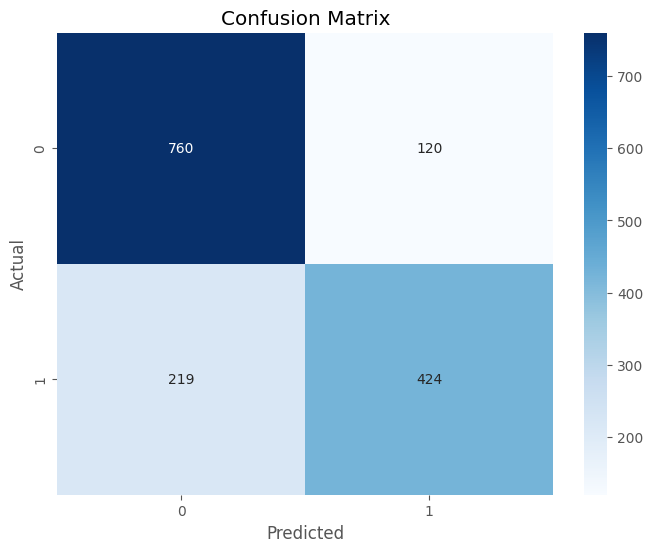

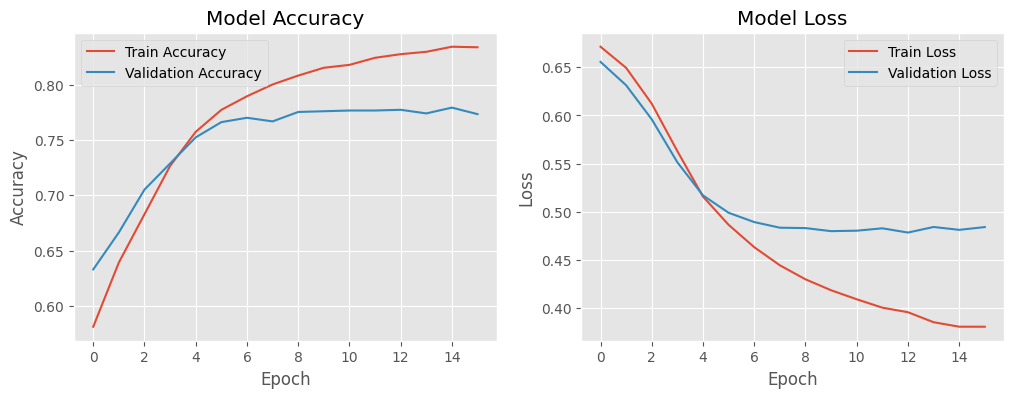

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
  Dense, LSTM, Embedding, Dropout, Bidirectional, SimpleRNN, GRU
)
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(x_train)


from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam, RMSprop
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

x_train, y_train, x_val, y_val, x_test = read_and_split_data()

# Assuming the text column is the one that needs to be processed for LSTM
# Tokenization and padding for the text data
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train, maxlen=10)

x_val = tokenizer.texts_to_sequences(x_val)
x_val = pad_sequences(x_val, maxlen=10)

# Building the LSTM model
def create_model(ann_units=64, dropout_rate=0.5, embedding_dim=20, relu_units=64, embedding_input_dim=2000, optimizer='adam', loss='binary_crossentropy', relu=False):
  model = Sequential(name="Model")
  model.add(Embedding(embedding_input_dim, embedding_dim, name='embedding'))
  model.add((SimpleRNN(ann_units, name='RNN')))
  if relu:
    model.add(Dense(relu_units, activation='relu', name='relu'))
    model.add(Dropout(dropout_rate, name='dropout'))
  model.add(Dense(1, activation='sigmoid', name='sigmoid'))
  model.build(input_shape=(None, embedding_dim))
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  return model

# Implement EarlyStopping and ModelCheckpoint
early_stopping = EarlyStopping(
  monitor='val_loss', 
  patience=3, 
  restore_best_weights=True
)
checkpoint = ModelCheckpoint(
  filepath='../model_checkpoint/RNN-{epoch:02d}-{val_loss:.2f}.h5', 
  monitor='val_loss', save_best_only=True, save_weights_only=True
)

model = create_model(optimizer=RMSprop(learning_rate=1e-4), relu=True, ann_units=32, embedding_dim=10)
log.debug(model.summary())

# Customize the run name and tags
CURRENT_DATE = datetime.now()

with mlflow.start_run(run_name=f"disaster_tweets_{CURRENT_DATE.strftime('%Y_%m_%d_%H_%M_%S')}",
                      experiment_id=experiment_id,
                      tags={"version": "v1", "priority": "P1", "Dataset": "Disaster Tweets"},
                      description="Disaster tweets classification modeling") as mlf_run:
  # Log model parameters
  mlflow.log_params({
      'model_name': 'RNN',
      'learning_rate': 1e-4,
      'ann_units': 32,
      'dropout_rate': 0.5,
      'embedding_dim': 10,
      'relu_units': 64,
      'optimizer': 'adam',
      'loss': 'binary_crossentropy',
      'epochs': 20,
      'batch_size': 32  # Assuming batch size, adjust if different
  })

  # Train the model
  history = model.fit(
      x_train, 
      y_train, 
      epochs=20, 
      validation_data=(x_val, y_val), 
      verbose=1,
      callbacks=[early_stopping, checkpoint]  # Add EarlyStopping
  )

  # Evaluate the model on validation set
  loss, accuracy = model.evaluate(x_val, y_val)
  log.debug(f"Validation accuracy: {accuracy:.4f}")

  # Log metrics to MLflow
  mlflow.log_metric('val_loss', loss)
  mlflow.log_metric('val_accuracy', accuracy)

  # Log training history
  for metric_name, metric_values in history.history.items():
      for epoch, value in enumerate(metric_values):
          mlflow.log_metric(metric_name, value, step=epoch)

  # Make predictions on validation set
  y_pred = (model.predict(x_val) > 0.5).astype("int32")

  # Print classification report
  class_report = classification_report(y_val, y_pred, output_dict=True)
  log.debug("\n" + classification_report(y_val, y_pred))

  # Log classification report
  mlflow.log_dict(class_report, 'classification_report.json')

  # Create confusion matrix
  conf_matrix = confusion_matrix(y_val, y_pred)
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
  plt.title('Confusion Matrix')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.savefig(f'../reports/mlflow/confusion_matrix.png')
  mlflow.log_artifact('../reports/mlflow/confusion_matrix.png')

  # Plot training history
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig(f'../reports/mlflow/training_history.png')
  mlflow.log_artifact('../reports/mlflow/training_history.png')

  # Log the model with a custom name
  mlflow.tensorflow.log_model(model, artifact_path='model', registered_model_name='DisasterTweetsRNN')


2024-08-05 23:52:00 [debug    ] 
X train: (6090, 3)
Y train: (6090,)
X test: (1523, 3)
Y test: (1523,) filename=disaster_tweets_logging.ipynb hostname=192.168.1.23 ip_address=192.168.1.23


Model: "Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 15, 15)         │        30,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BiLSTM (GRU)                    │ (None, 32)             │         4,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sigmoid (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,737 (135.69 KB)

 Trainable params: 34,737 (135.69 KB)

 Non-trainable params: 0 (0.00 B)

2024-08-05 23:52:00 [debug    ] filename=disaster_tweets_logging.ipynb hostname=192.168.1.23 ip_address=192.168.1.23
Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6018 - loss: 0.6670 - val_accuracy: 0.7544 - val_loss: 0.5311
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8011 - loss: 0.4671 - val_accuracy: 0.8076 - val_loss: 0.4373
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8326 - loss: 0.3935 - val_accuracy: 0.7984 - val_loss: 0.4464
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8420 - loss: 0.3782 - val_accuracy: 0.8070 - val_loss: 0.4396
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8475 - loss: 0.3655 - val_accuracy: 0.8037 - val_loss: 0.4484
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8100 - loss: 0.4313
2024-08-05 23:52:18 [debug    ] Validation accuracy: 0.8076    filename=disaster_tweets_logging.ipynb hostname=192.168.1.23 ip_address=192.168.1.23
48/48 ━━━━━━━━━━━

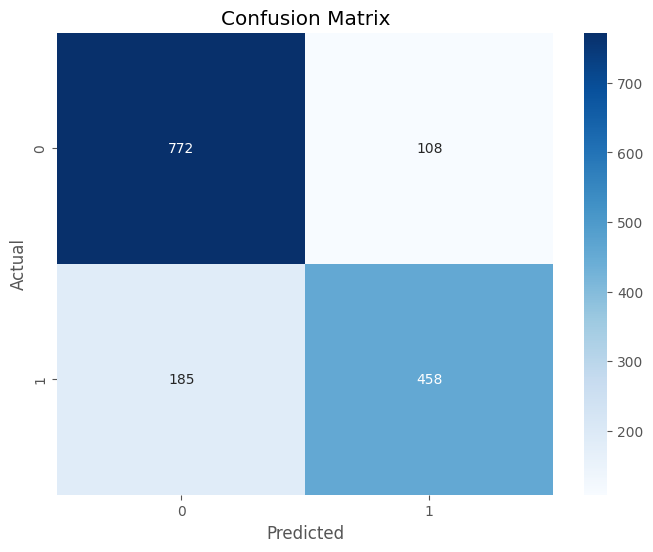

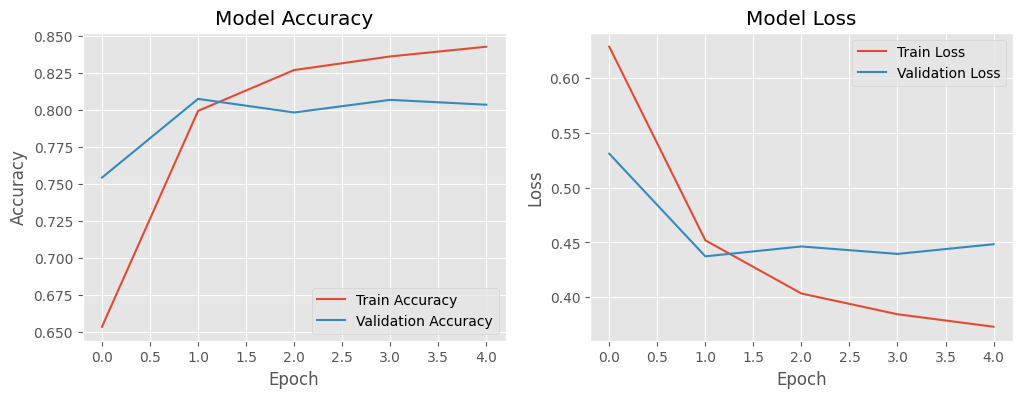

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
  Dense, LSTM, Embedding, Dropout, Bidirectional, GRU,
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

train, test = get_dataset(raw=False)

FEATURES = MODEL_PARAMS["DEFAULT_FEATURE_NAMES"]
TARGET_NAME = MODEL_PARAMS["TARGET_NAME"]

x_train, x_val, y_train, y_val = train_test_split(
  train.loc[:, FEATURES],
  train[TARGET_NAME],
  test_size=MODEL_PARAMS["TEST_SIZE"],
  random_state=SEED
)

log.debug(f"\nX train: {x_train.shape}\nY train: {y_train.shape}\n"
            f"X test: {x_val.shape}\nY test: {y_val.shape}")

train['keyword'] = train['keyword'].fillna('')
x_train['keyword'] = x_train['keyword'].fillna('')
x_val['keyword'] = x_val['keyword'].fillna('')

# Assuming the text column is the one that needs to be processed for LSTM
# Tokenization and padding for the text data
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(train['keyword'] + ' ' + train['text'])

x_train = tokenizer.texts_to_sequences(x_train['keyword'] + ' ' + x_train['text'])
x_train = pad_sequences(x_train, maxlen=100)

x_val = tokenizer.texts_to_sequences(x_val['keyword'] + ' ' + x_val['text'])
x_val = pad_sequences(x_val, maxlen=100)

y_train = y_train.values
y_val = y_val.values

# Building the LSTM model
def create_model(lstm_units=32, dropout_rate=0.5, embedding_dim=15, relu_units=64, embedding_input_dim=2000, optimizer='rmsprop', loss='binary_crossentropy'):
  model = Sequential(name="Model")
  model.add(Embedding(embedding_input_dim, embedding_dim, name='embedding'))
  model.add(GRU(lstm_units, name='BiLSTM'))
  #model.add(Dense(relu_units, activation='relu', name='relu1'))
  model.add(Dropout(dropout_rate, name='dropout'))
  model.add(Dense(1, activation='sigmoid', name='sigmoid'))
  model.build(input_shape=(None, embedding_dim))
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  return model

model = create_model()
log.debug(model.summary())

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stopping], verbose=1)

# Evaluate the model on validation set
loss, accuracy = model.evaluate(x_val, y_val)
log.debug(f"Validation accuracy: {accuracy:.4f}")

# Make predictions on validation set
y_pred = (model.predict(x_val) > 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

# Print classification report
log.debug("\n" + classification_report(y_val, y_pred))

# Create confusion matrix
confusion_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

2024-08-07 08:03:52 [debug    ] Num GPUs Available: 1          filename=disaster_tweets_logging.ipynb hostname=192.168.1.32 ip_address=192.168.1.32
2024-08-07 08:03:52 [debug    ] 
X train: (6090, 3)
Y train: (6090,)
X test: (1523, 3)
Y test: (1523,) filename=disaster_tweets_logging.ipynb hostname=192.168.1.32 ip_address=192.168.1.32


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/50
191/191 [==============================] - 345s 2s/step - loss: 0.6857 - accuracy: 0.5847 - val_loss: 0.6652 - val_accuracy: 0.6684
Epoch 2/50
191/191 [==============================] - 141s 721ms/step - loss: 0.6470 - accuracy: 0.6826 - val_loss: 0.6201 - val_accuracy: 0.6986
Epoch 3/50
191/191 [==============================] - 141s 732ms/step - loss: 0.5904 - accuracy: 0.7397 - val_loss: 0.5758 - val_accuracy: 0.7288
Epoch 4/50
191/191 [==============================] - 126s 657ms/step - loss: 0.5394 - accuracy: 0.7594 - val_loss: 0.5291 - val_accuracy: 0.7708
Epoch 5/50
191/191 [==============================] - 112s 581ms/step - loss: 0.5084 - accuracy: 0.7796 - val_loss: 0.5040 - val_accuracy: 0.7787
Epoch 6/50
191/191 [==============================] - 106s 553ms/step - loss: 0.4818 - accuracy: 0.7961 - val_loss: 0.4902 - val_accuracy: 0.7814
Epoch 7/50
191/191 [==============================] - 107s 554ms/step - loss: 0.4662 - accuracy: 0.8020 - val_loss: 0.4766 - va

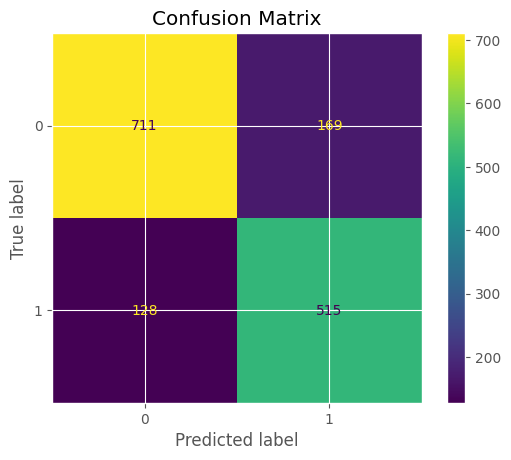

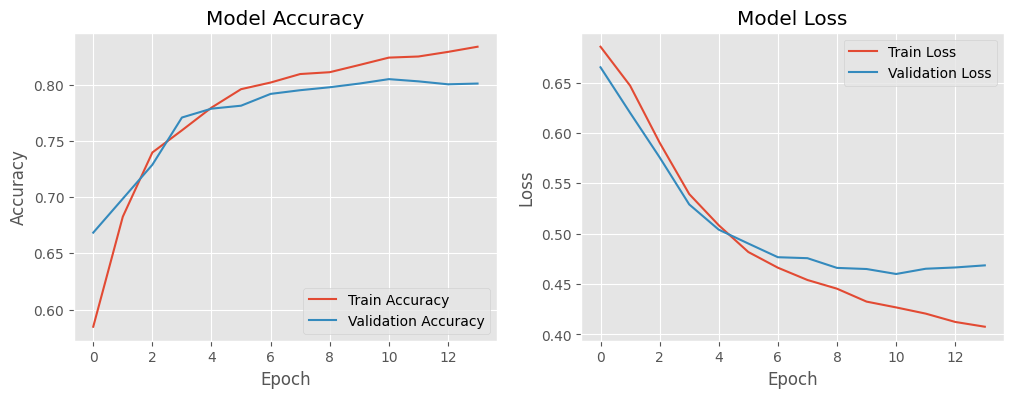

In [5]:
import tensorflow as tf
log.debug(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")
   
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers.legacy import Adam  # Changed to RMSProp optimizer
from tensorflow.keras.callbacks import EarlyStopping  # Import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2 

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# Implement EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

train, test = get_dataset(raw=False)

FEATURES = MODEL_PARAMS["DEFAULT_FEATURE_NAMES"]
TARGET_NAME = MODEL_PARAMS["TARGET_NAME"]

x_train, x_val, y_train, y_val = train_test_split(
  train.loc[:, FEATURES],
  train[TARGET_NAME],
  test_size=MODEL_PARAMS["TEST_SIZE"],
  random_state=SEED
)

log.debug(f"\nX train: {x_train.shape}\nY train: {y_train.shape}\n"
            f"X test: {x_val.shape}\nY test: {y_val.shape}")

train['keyword'] = train['keyword'].fillna('')
x_train['keyword'] = x_train['keyword'].fillna('')
x_val['keyword'] = x_val['keyword'].fillna('')

# Concatenate 'text' and 'keyword' columns
x_train['concat_text'] = x_train['text'] + ' ' + x_train['keyword']
x_val['concat_text'] = x_val['text'] + ' ' + x_val['keyword']

# Load pre-trained model and tokenizer
model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Prepare data for training
train_encodings = tokenizer(x_train['concat_text'].tolist(), truncation=True, padding=True, return_tensors='tf')
val_encodings = tokenizer(x_val['concat_text'].tolist(), truncation=True, padding=True, return_tensors='tf')

# Convert labels to numpy arrays
train_labels = y_train.values
val_labels = y_val.values

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=train_labels)
class_weights = {0: class_weights[0], 1: class_weights[1]}

model.compile(optimizer=Adam(learning_rate=5e-7), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=SparseCategoricalAccuracy('accuracy'))
# Train the model
history = model.fit(
    {
      'input_ids': train_encodings['input_ids'], 
      'attention_mask': train_encodings['attention_mask']}, 
    train_labels, 
    epochs=50, 
    validation_data=(
        {
          'input_ids': val_encodings['input_ids'], 
          'attention_mask': val_encodings['attention_mask']}, 
        val_labels
    ), 
    verbose=1,
    class_weight=class_weights,  # Use class weights
    callbacks=[early_stopping]  # Add EarlyStopping
)

# Evaluate the model on validation set
loss, accuracy = model.evaluate(val_encodings, val_labels)
log.debug(f"Validation accuracy: {accuracy:.4f}")

# Make predictions on validation set
y_pred = model.predict(val_encodings).logits.argmax(-1)

# Print classification report
log.debug("\n" + classification_report(val_labels, y_pred))

# Create confusion matrix
confusion_matrix = confusion_matrix(val_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
disp.plot()

plt.title('Confusion Matrix')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<a id="5"></a> 
#### Conclusion [⏮️](#4)[👆🏽](#0)[⏭️](#6)

<a id="6"></a> 
#### <i>References</i> [⏮️](#5)[👆🏽](#0)[⏭️](#7)

Here is some text with a reference to the [Python documentation](https://docs.python.org/).

...

Here are some references for more information on the libraries used:

- [Pandas documentation](https://pandas.pydata.org/docs/)
- [NumPy documentation](https://numpy.org/doc/stable/)

🍀 Auteurs
- 🧑🏾‍💻 Kikia DIA
- 🧑🏾‍💻 Mouhamadou Naby DIA
- 🧑🏾‍💻 Ndeye Awa SALANE

🍀 Affiliations
- 🎓 Ecole Polytechnique de THIES

🍀 Département 
- 💻 Génie Informatique et Télécommunications

🍀 Niveau
- 📚 DIC3